In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jeissonbarrantes","key":"13a6aa593f99ded08d17e0de70616a11"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
#!kaggle datasets download -d jeissonbarrantes/dataset

In [ ]:
!kaggle datasets download -d jeissonbarrantes/muestra

100% 441M/442M [00:24<00:00, 26.1MB/s]
100% 442M/442M [00:24<00:00, 19.3MB/s]


In [ ]:
#!unzip "./fma-small.zip" -d "./"

In [ ]:
!unzip "./muestra.zip" -d "./"

In [ ]:
!pip install scipy pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

!pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from pydub import AudioSegment
from pydub.utils import audioop
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
from skimage.feature import peak_local_max
from scipy.spatial.distance import hamming
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import (generate_binary_structure, iterate_structure, binary_erosion)
import pandas as pd

<ipython-input-8-5a26e53b3694>:11: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter
<ipython-input-8-5a26e53b3694>:12: DeprecationWarning: Please use `generate_binary_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import (generate_binary_structure, iterate_structure, binary_erosion)
<ipython-input-8-5a26e53b3694>:12: DeprecationWarning: Please use `iterate_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import (generate_binary_structure, iterate_structure, binary_erosion)
<ipython-input-8-5a26e53b3694>:12: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology im

In [ ]:
filename = './muestra/000002.mp3'
audiofile = AudioSegment.from_file(filename)
print("Frame Rate:", audiofile.frame_rate, "Hz")
print("Cantidad de canales: ", audiofile.channels)
print("Bit-depth: ", 8* audiofile.sample_width)
audiofile

Frame Rate: 44100 Hz
Cantidad de canales:  2
Bit-depth:  16


In [ ]:
channels = np.array(audiofile.get_array_of_samples()).reshape(audiofile.channels, -1, order='F')



Cantidad de frecuencias 2049
Cantidad de segmentos temporales 644


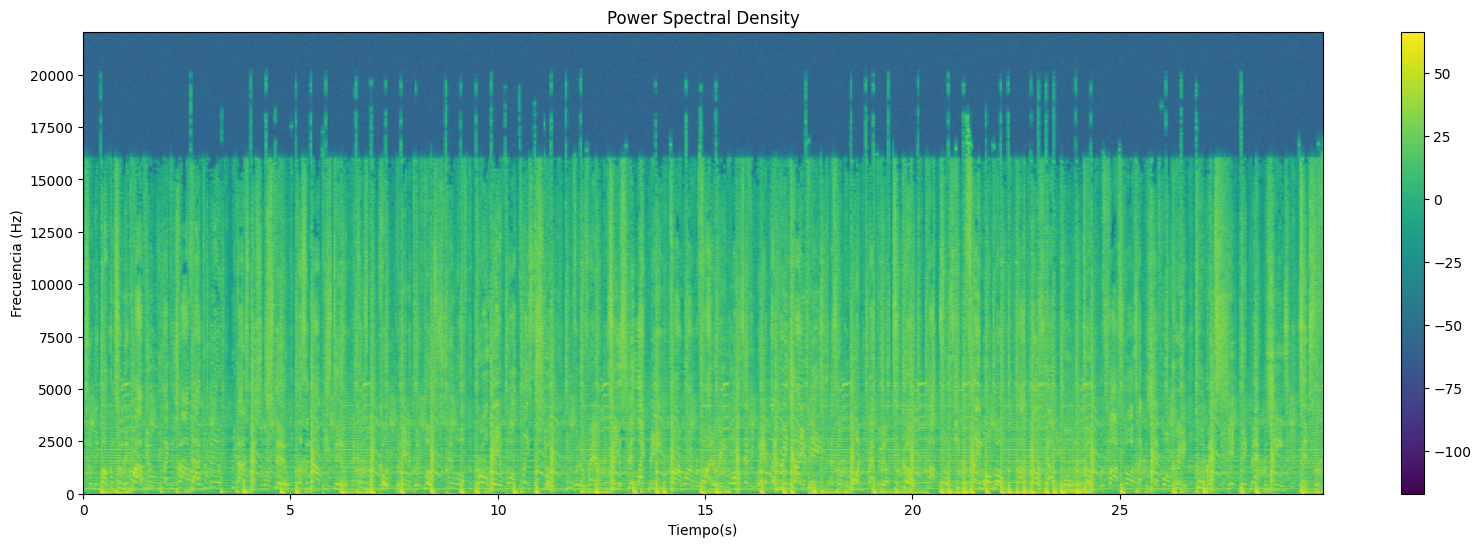

In [ ]:
WINDOW_SIZE = 4096

OVERLAP_RATIO = 0.5

spectrum, freqs, times = mlab.specgram(
      channels[0],
      NFFT=WINDOW_SIZE,
      Fs = audiofile.frame_rate,
      window=mlab.window_hanning,
      noverlap=int(WINDOW_SIZE* OVERLAP_RATIO),
      scale_by_freq = True)

spectrum = 10* np.log10(spectrum)
spectrum = np.nan_to_num(spectrum)

print("Cantidad de frecuencias", len(freqs))
print("Cantidad de segmentos temporales", len(times))

plt.figure(figsize=(20,6))
plt.title("Power Spectral Density")
plt.xlabel("Tiempo(s)")
plt.ylabel("Frecuencia (Hz)")
plt.imshow(spectrum, aspect="auto", origin="lower", extent=[0,times[-1],0, freqs[-1]])
plt.colorbar()
plt.show()

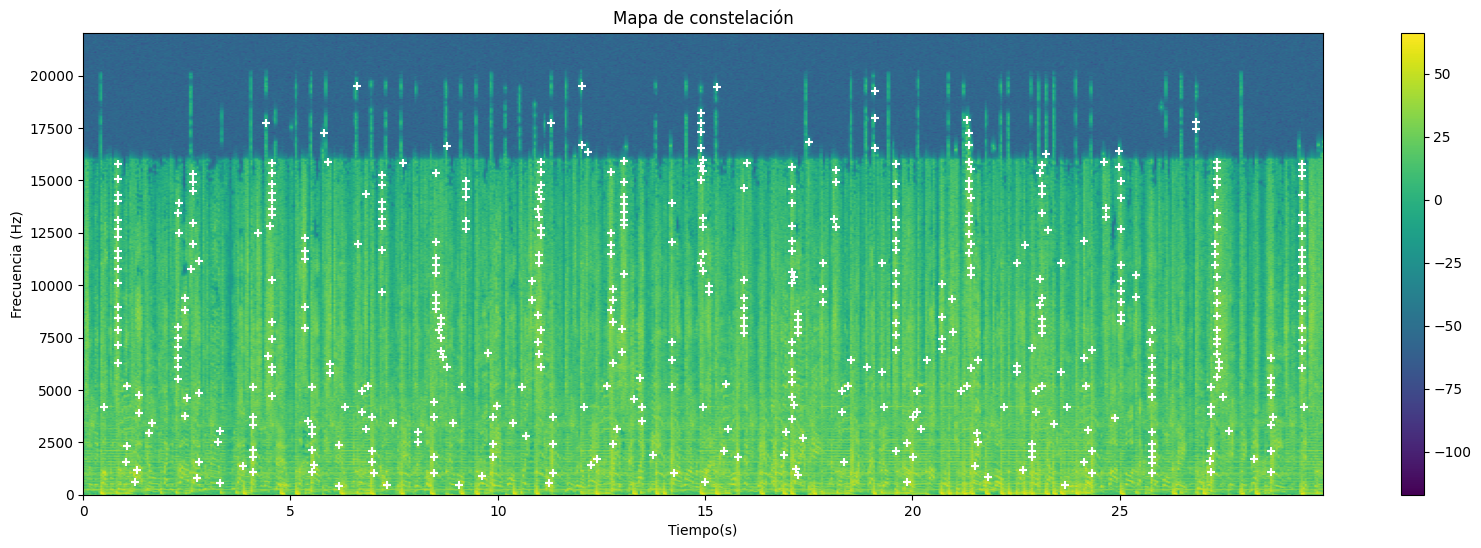

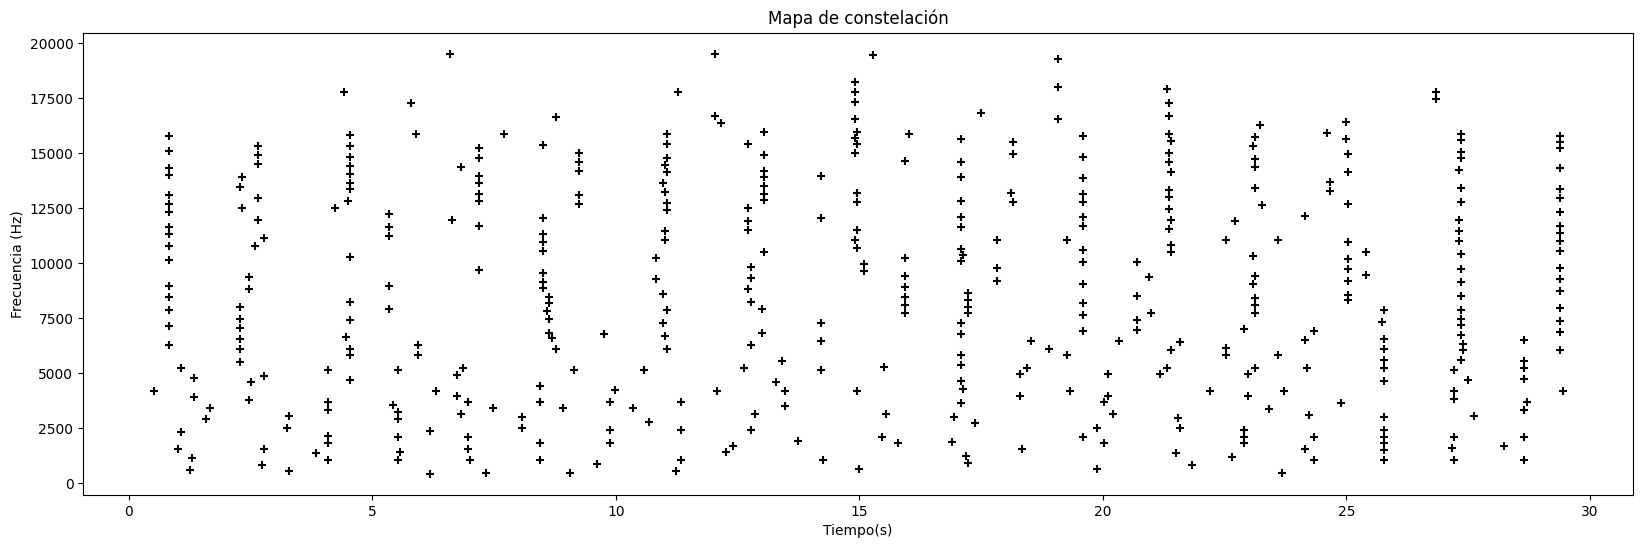

In [ ]:
PEAK_NEIGHBORHOOD_SIZE = 22

DEFAULT_AMP_MIN = 10

peaks = peak_local_max(spectrum,
                       min_distance=PEAK_NEIGHBORHOOD_SIZE,
                       threshold_abs = DEFAULT_AMP_MIN,
                       exclude_border=10,
                       num_peaks=2000)
time_idx=peaks[:,1]
frequency_idx = peaks[:,0]

plt.figure(figsize=(20,6))
plt.title("Mapa de constelación")
plt.xlabel("Tiempo(s)")
plt.ylabel("Frecuencia (Hz)")
plt.imshow(spectrum, aspect="auto", origin='lower', extent=[0, times[-1],0, freqs[-1]])
plt.colorbar()
plt.scatter(times[time_idx], freqs[frequency_idx],c='w', marker='+')
plt.show()
plt.figure(figsize=(20,6))
plt.title("Mapa de constelación")
plt.xlabel("Tiempo(s)")
plt.ylabel("Frecuencia (Hz)")
plt.scatter(times[time_idx], freqs[frequency_idx],c='black', marker='+')
plt.show()

# IMPLEMENTACIÓN

In [ ]:
#training_dir = './dataset'
training_dir = './muestra'
query_dir = './testset'
training_files = [os.path.join(training_dir, f) for f in os.listdir(training_dir)]
query_files = [os.path.join(query_dir, f) for f in os.listdir(query_dir)]

In [ ]:
class AudioAnalyzer:
    def __init__(self, filenames):
        self.filenames = filenames
        self.audiofiles = []
        self.channels = []
        self.spectrums = []
        self.freqs = []
        self.times = []
        self.features = {}
        self.peaks = {}
        self.peaks_freqs = {}
        self.num_peaks = 20

    def load_audio(self):
        for filename in self.filenames:
            self.audiofile = AudioSegment.from_file(filename)
            self.audiofiles.append(self.audiofile)

        self.extract_channels()

    def extract_channels(self):
        for audiofile in self.audiofiles:
            channels = np.array(audiofile.get_array_of_samples()).reshape(audiofile.channels, -1, order='F')
            self.channels.append(channels)
        self.calculate_spectrum()

    def calculate_spectrum(self):
        WINDOW_SIZE = 4096
        OVERLAP_RATIO = 0.5

        for channels in self.channels:
            spectrum, freqs, times = mlab.specgram(
            channels[0],
            NFFT=WINDOW_SIZE,
            Fs = self.audiofile.frame_rate,
            window=mlab.window_hanning,
            noverlap=int(WINDOW_SIZE* OVERLAP_RATIO),
            scale_by_freq = True)

            spectrum = 10* np.log10(spectrum)
            spectrum = np.nan_to_num(spectrum)

            self.spectrums.append(spectrum)
            self.freqs.append(freqs)
            self.times.append(times)
        for filename in self.filenames:
          self.features[filename] = [spectrum, freqs, times]
        self.find_peaks()



    def find_peaks(self):
        PEAK_NEIGHBORHOOD_SIZE = 22
        DEFAULT_AMP_MIN = 10

        for filename, spectrum in zip(self.filenames, self.spectrums):

            peaks = peak_local_max(
                spectrum,
                min_distance=PEAK_NEIGHBORHOOD_SIZE,
                threshold_abs=DEFAULT_AMP_MIN,
                exclude_border=10,
                num_peaks= self.num_peaks
            )
            self.peaks[filename] = np.array(peaks)

            i = 1  # Columna que queremos obtener
            peaks_freq = [fila[i] for fila in peaks]
            peaks_freq = np.array(peaks_freq)

            self.peaks_freqs[filename] = peaks_freq
        return self.peaks_freqs, self.peaks, self.spectrums, self.times, self.freqs, self.features


In [ ]:
analyzer_training = AudioAnalyzer(training_files)
analyzer_training.load_audio()

<ipython-input-18-fd5cbf7e8937>:40: RuntimeWarning: divide by zero encountered in log10
  spectrum = 10* np.log10(spectrum)


In [ ]:
from scipy.spatial.distance import cosine

class LSH:
    def __init__(self):
        self.hash_table = dict()
        self.dimension = 20
        self.hiperplanos = []
        self.candidates = []
        self.hashcodes = {}

    def generar_hiperplanos(self):
        self.hiperplanos = []
        for _ in range(k):
            self.normal_vector = np.random.choice([-1, 1], size=self.dimension)
            self.hiperplanos.append(self.normal_vector)

        return self.hiperplanos


    def generar_hashcode(self, vector_entrada, hiperplanos):

        hashcode = ''
        for hiperplano in self.hiperplanos:
            producto_punto = np.dot(hiperplano, vector_entrada)
            if producto_punto <= 0:
                hashcode += '0'
            else:
                hashcode += '1'

        return hashcode


    def build_hash_table(self, list_peaks):

        for filename in training_files:
            self.hashcodes[filename] = self.generar_hashcode(list_peaks[filename], hiperplanos_generados)
        for filename in self.hashcodes:
            integer_value = int(self.hashcodes[filename], 2)
            if integer_value in self.hash_table:
                self.hash_table[integer_value].append([filename, list_peaks[filename]])

            else:
                self.hash_table[integer_value] = [[filename, list_peaks[filename]]]
        return self.hash_table


    def query(self, peaks_query):
        self.candidates.clear()
        query_hashcode = self.generar_hashcode(peaks_query, hiperplanos_generados)
        integer_value = int(query_hashcode, 2)
        if integer_value in self.hash_table:
            for i in  range(len(self.hash_table[integer_value])):
              d = cosine(peaks_query, self.hash_table[integer_value][i][1])
              self.candidates.append([self.hash_table[integer_value][i][0], d ])
        else:
          print("No está en la base de datos")
        return self.candidates



In [ ]:
training = LSH()
k = 6

In [ ]:
hiperplanos_generados = training.generar_hiperplanos()


In [ ]:
training.build_hash_table(analyzer_training.peaks_freqs)

{21: [['./muestra/001929.mp3',
   array([618, 568, 587, 505, 413, 301, 268, 372, 405, 216, 154, 307,  75,
           70, 272, 377,  18, 453, 330, 159])],
  ['./muestra/007548.mp3',
   array([330,  72, 561, 191, 380, 492, 612, 491, 562, 125,  45, 249, 122,
          218, 612,  68, 423,  11, 439, 193])],
  ['./muestra/006608.mp3',
   array([ 95, 156,  39, 180, 254, 372, 302, 215,  13, 429, 415, 120, 314,
          315, 599, 598, 515, 314, 183, 391])],
  ['./muestra/007386.mp3',
   array([403,  34, 349, 316, 394, 257, 224, 118,  74,  41, 165, 316, 349,
          553, 257, 581, 210, 394, 316, 118])],
  ['./muestra/006459.mp3',
   array([550, 232, 526, 280, 353, 300, 609, 269, 231,  95, 581,  18, 164,
          631, 577, 475, 583,  80, 232, 558])],
  ['./muestra/015210.mp3',
   array([ 77, 410, 300, 214,  90, 326, 492, 466, 415, 523, 415,  75, 129,
           17, 354, 241, 452, 157, 363,  26])],
  ['./muestra/004777.mp3',
   array([561,  73,  36, 485, 538, 461, 492, 414, 559, 330,  55, 616,

**QUERY**

In [ ]:
analyzer_query = AudioAnalyzer(query_files)
analyzer_query.load_audio()

In [ ]:
analyzer_query.peaks_freqs

{'./testset/000190.mp3': array([ 24, 190,  47, 502, 537, 604, 505, 102, 415, 394, 470, 441, 154,
        470,  24, 238, 574, 598,  25,  26]),
 './testset/000194.mp3': array([366, 212, 476, 294, 205,  54, 204,  53, 317, 150, 268, 365, 116,
        151, 437, 325, 485, 439, 519, 325]),
 './testset/154306.mp3': array([467, 326, 326, 438, 554, 580, 173,  18, 492, 619, 522, 412, 471,
        499, 614, 587, 438,  83, 354, 263]),
 './testset/000182.mp3': array([192, 597, 146, 457, 206, 269, 560, 480, 298, 370, 339,  82,  48,
        521, 125, 304, 388, 116, 441,  13]),
 './testset/000140.mp3': array([558, 523, 290, 233,  92, 401, 434, 362, 166,  58, 200, 559, 632,
        630, 632, 545, 630,  59, 632, 632]),
 './testset/086259.mp3': array([564, 198, 162, 594,  53, 503, 419, 622,  10, 376, 348, 122, 456,
        241, 284, 252, 625, 596, 555, 186]),
 './testset/000005.mp3': array([567,  23, 121, 359, 396, 323, 127, 453, 365,  74, 281, 505, 203,
        628, 539, 421, 493, 577, 420,  60]),
 './te

In [ ]:
candidates = training.query(analyzer_query.peaks_freqs['./testset/154306.mp3'])

In [ ]:
candidates

# Analizando

In [ ]:
filename = './testset/000141.mp3'
audiofile = AudioSegment.from_file(filename)
audiofile


In [ ]:
filename = './dataset/000140.mp3'
audiofile = AudioSegment.from_file(filename)
audiofile

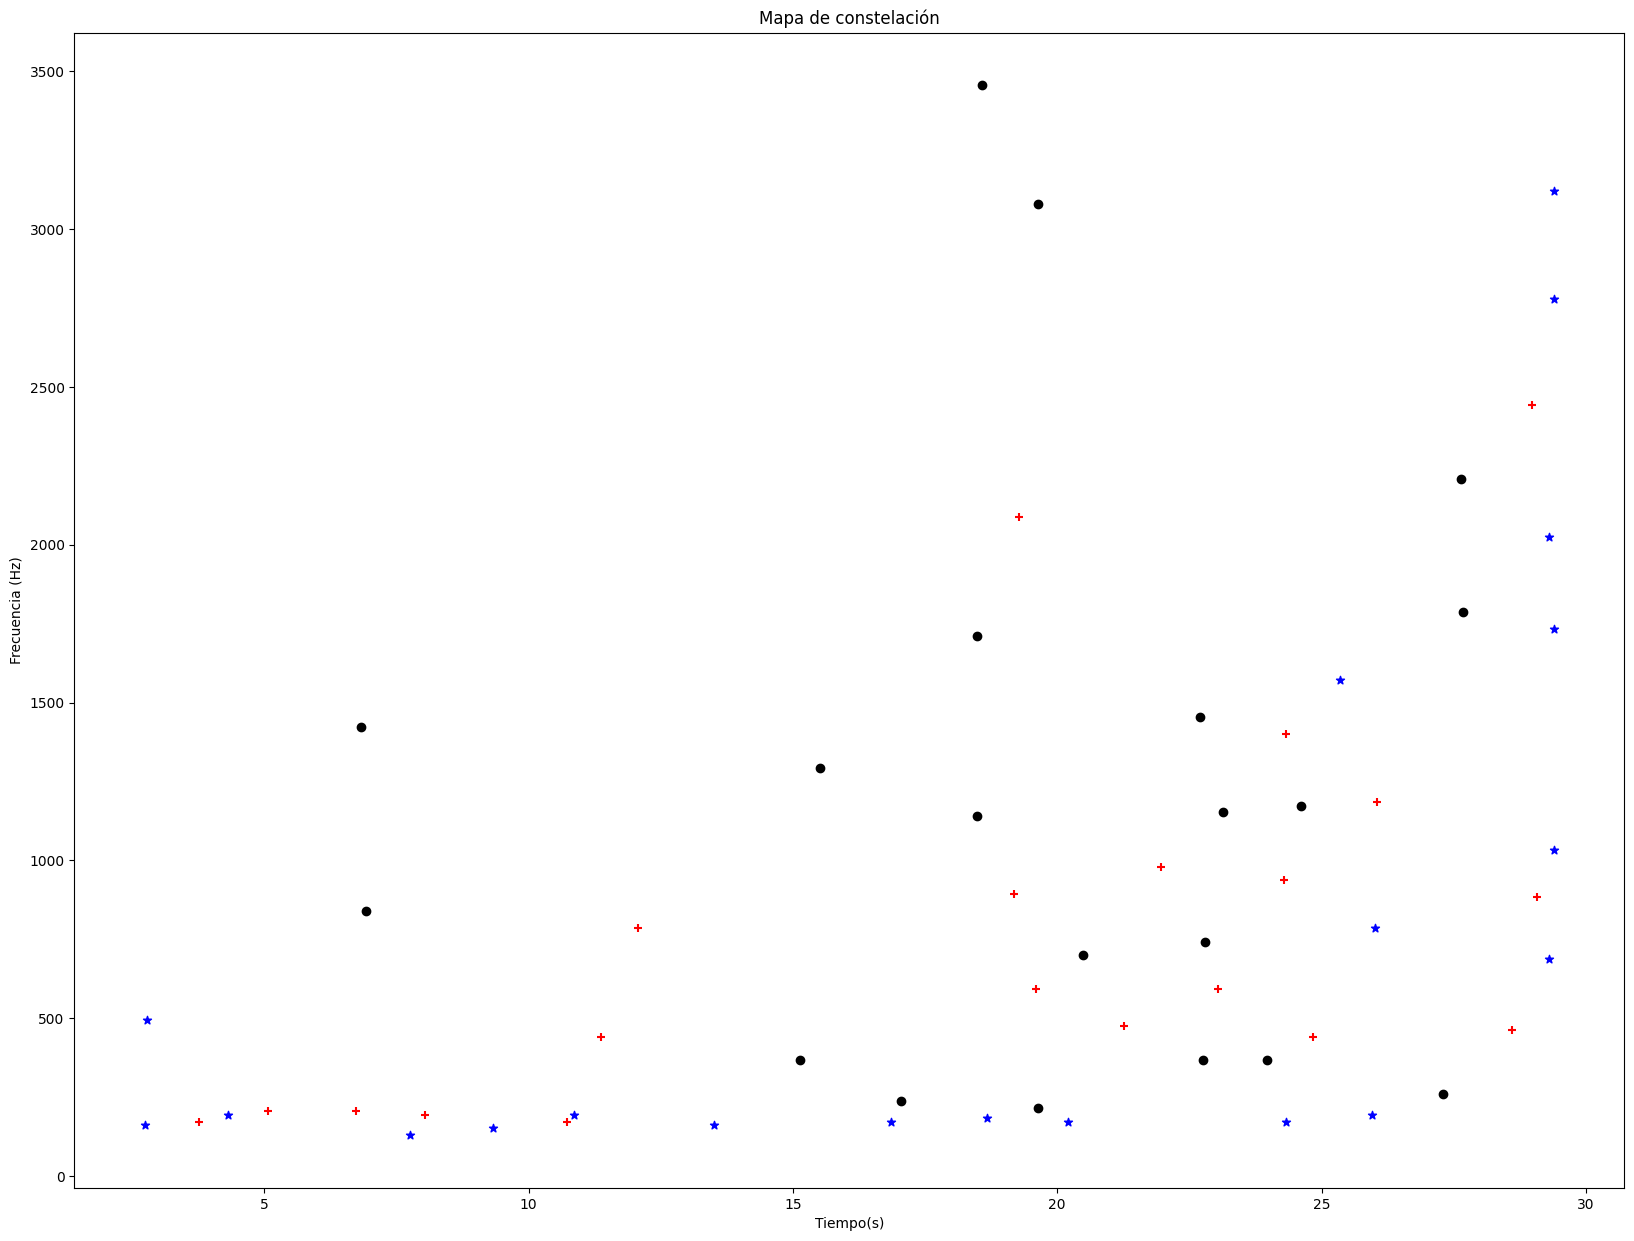

In [ ]:

time_idx=analyzer_training.peaks['./muestra/004017.mp3'][:,1]
frequency_idx = analyzer_training.peaks['./muestra/004017.mp3'][:,0]

time_idx_2=analyzer_training.peaks['./muestra/000140.mp3'][:,1]
frequency_idx_2 = analyzer_training.peaks['./muestra/000140.mp3'][:,0]

time_idx_query=analyzer_query.peaks['./testset/000141.mp3'][:,1]
frequency_idx_query = analyzer_query.peaks['./testset/000141.mp3'][:,0]

plt.figure(figsize=(20,15))
plt.title("Mapa de constelación")
plt.xlabel("Tiempo(s)")
plt.ylabel("Frecuencia (Hz)")
plt.scatter(analyzer_training.features['./muestra/004017.mp3'][2][time_idx], analyzer_training.features['./muestra/004017.mp3'][1][frequency_idx],c='black', marker='o')
plt.scatter(analyzer_training.features['./muestra/000140.mp3'][2][time_idx_2], analyzer_training.features['./muestra/000140.mp3'][1][frequency_idx_2],c='blue', marker='*')
plt.scatter(analyzer_query.features['./testset/000141.mp3'][2][time_idx_query], analyzer_query.features['./testset/000141.mp3'][1][frequency_idx_query],c='red', marker='+')

plt.show()

In [ ]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=0901353041169955306d2ce33fc815365a24c11d230b4937499e57362afe5ea5
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn


In [ ]:
query_files[2]

'./testset/154306.mp3'

7


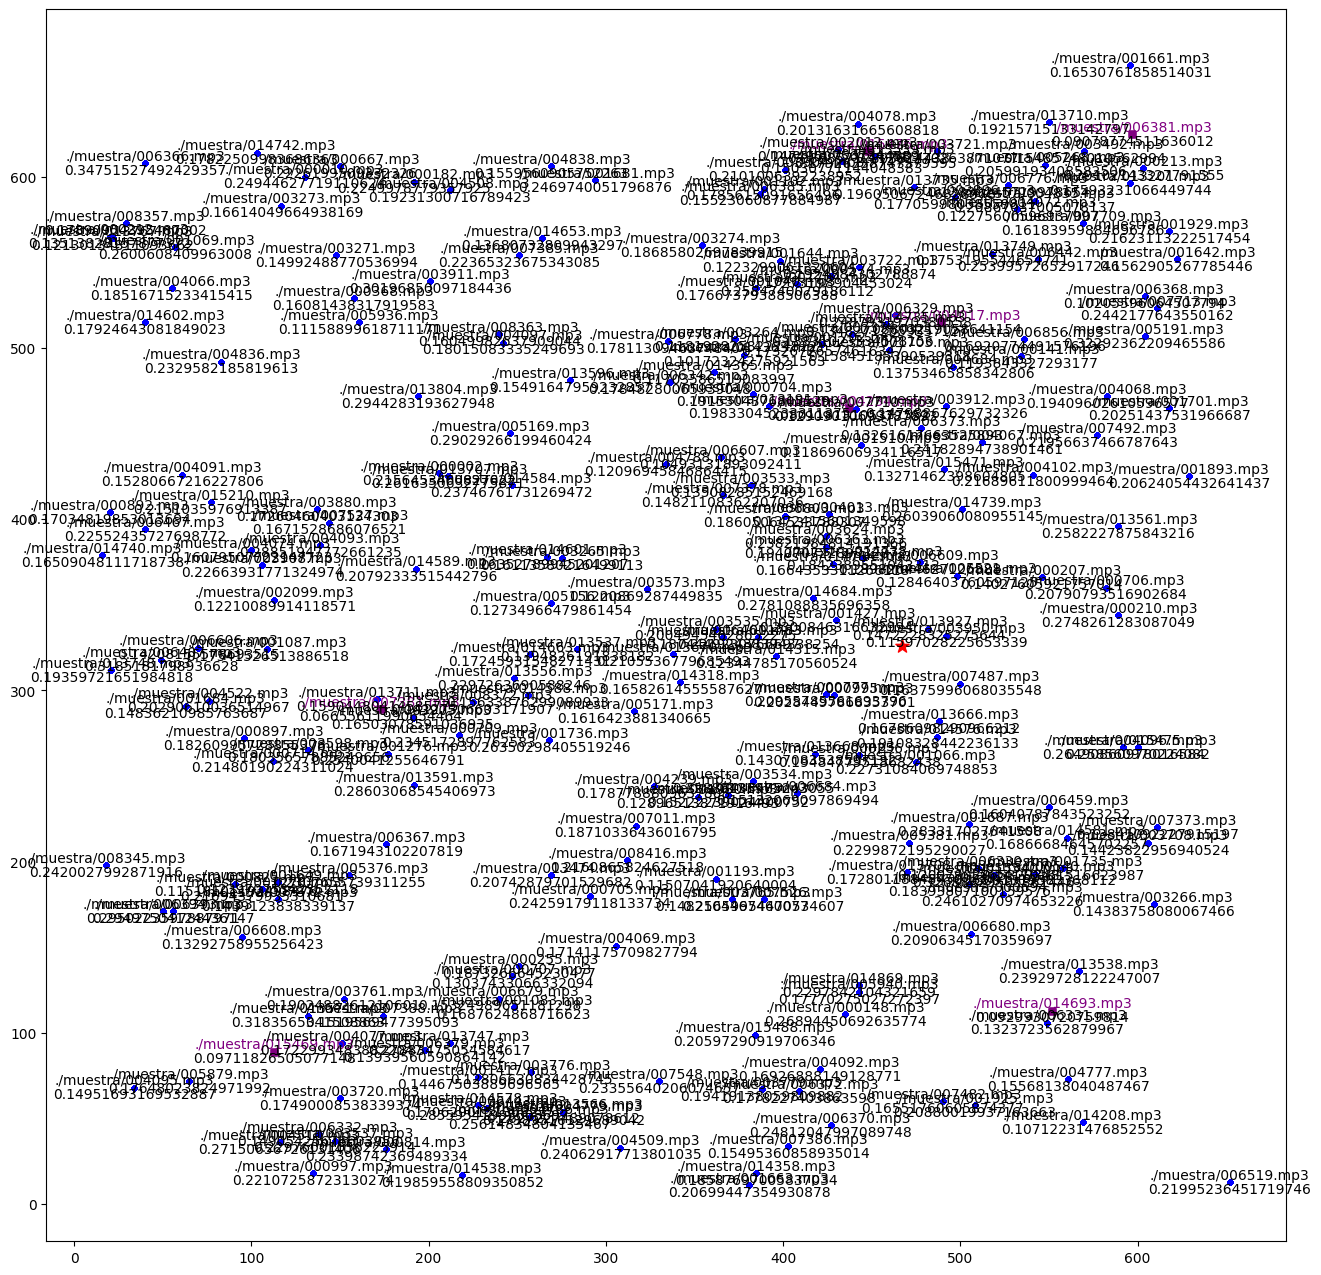

In [ ]:
import matplotlib.pyplot as plt

query = query_files[2]
all_candidates = dict()
neighbors = dict()
x_neighbor = []
y_neighbor = []
x = []
y = []
for i in range(len(candidates)):
    if candidates[i][1] <= 0.1:
       neighbors[candidates[i][0]] = (analyzer_training.peaks_freqs[candidates[i][0]] ,candidates[i][1] )
    else:
       all_candidates[candidates[i][0]] = (analyzer_training.peaks_freqs[candidates[i][0]] ,candidates[i][1] )


print(len(neighbors))
for key in neighbors:
    x_neighbor.append(neighbors[key][0][0])
    y_neighbor.append(neighbors[key][0][1])

for key in all_candidates:
    x.append(all_candidates[key][0][0])
    y.append(all_candidates[key][0][1])

plt.figure(figsize=(16, 16))
plt.scatter(analyzer_query.peaks_freqs[query][0],analyzer_query.peaks_freqs[query][1],color="red",marker="*", s=100)

for key in neighbors:
    plt.scatter(x_neighbor,y_neighbor, color="purple", marker="s", s=20)
    plt.annotate(key,(neighbors[key][0][0],neighbors[key][0][1]),ha="center",va="bottom", color="purple")
    plt.annotate(neighbors[key][1],(neighbors[key][0][0],neighbors[key][0][1]-0.01),ha="center",va="top")




for key in all_candidates:
    plt.scatter(x,y,color="blue",marker="o",s=10)
    plt.annotate(key,(all_candidates[key][0][0],all_candidates[key][0][1]),ha="center",va="bottom")
# poner una etiqueta con la distancia coseno debajo de cada punto vecino
for key in all_candidates:
    # usar un pequeño desplazamiento en la coordenada y para evitar la superposición
    plt.annotate(all_candidates[key][1],(all_candidates[key][0][0],all_candidates[key][0][1]-0.01),ha="center",va="top")

plt.show()


#Otra implementación


In [ ]:
!pip install py-lsh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
analyzer_training.peaks_freqs

In [ ]:
from py_lsh import LSHash
import pandas as pd

input_dim = 20
hash_size = 6
lsh = LSHash(hash_size, input_dim)

for peaks in analyzer_training.peaks_freqs:
    lsh.index(analyzer_training.peaks_freqs[peaks], extra_data=None)

results = lsh.query(analyzer_query.peaks_freqs['./testset/000141.mp3'], num_results=None, distance_func="cosine")

print(lsh.hash_tables)
display(pd.DataFrame(results))

0         1
0    (534, 495, 421, 615, 522, 457, 230, 244, 625, ...  0.000000
1    (433, 609, 615, 404, 545, 324, 287, 390, 421, ...  0.052614
2    (489, 515, 490, 333, 325, 587, 422, 440, 366, ...  0.067956
3    (415, 389, 356, 597, 453, 291, 228, 499, 207, ...  0.071658
4    (491, 429, 353, 528, 252, 565, 217, 487, 565, ...  0.073714
..                                                 ...       ...
440  (68, 249, 284, 193, 335, 126, 312, 605, 429, 4...  0.346989
441  (106, 615, 183, 142, 37, 184, 547, 97, 325, 21...  0.348983
442  (233, 56, 224, 130, 10, 607, 458, 420, 73, 349...  0.361717
443  (281, 89, 516, 113, 110, 36, 516, 36, 165, 114...  0.402721
444  (10, 123, 43, 202, 162, 83, 439, 465, 135, 294...  0.409269

[445 rows x 2 columns]